In [7]:
from datetime import *
from dateutil.relativedelta import *

# -- Some helpers
    
def round_down(m,n):
    return m // n * n

def pos_and_floor(x):
    x = np.floor(x)
    x[x<0] = 0
    return x

# rounds num_ago up to n, where n days ago was a Sunday
# returns first Sunday date and n
def floorSundayNumDaysAgo(now, num_ago):
    ago = (now-timedelta(days=num_ago))
    previous = ago + relativedelta(weekday=SU(-1))
    diff = now - previous
    
    return previous, diff.days

In [22]:
import pandas as pd
from numpy.random import randint
from random import random
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.pyplot as plt
from datetime import *
from dateutil.relativedelta import *
import warnings
warnings.filterwarnings("ignore")

# why did we choose SARIMA?
# -> assume data is stationary and seasonal

def GEN_DATA(days_ago, peak_consume, noise_sd=1, testing=False):
    
    # --- GENERATE DATA --- #
    '''
    Generate data that mimics a noisy periodic consumption that maxes at around peak_consume.
    
    days_ago is rounded so that days_ago from today lands on a Sunday.
    This is to align the peak consumption of our data on a consistent day of the week.
    Our assumption is that food consumption peaks on weekends and tapers off during mid-week.
    '''
    
    d = None
    if not testing:
        d, days_ago = floorSundayNumDaysAgo(date.today(), days_ago)
    
    PEAK_CONSUME = peak_consume - noise_sd # accounts for added noise

    mu, sig = 0, noise_sd # mean and standard deviation of noise
    noise = np.random.normal(mu, sig, days_ago)

    x = np.arange(0, days_ago)
    # center peaks at day 0 (days_ago)
    # period = 7 (week)
    # amplitude = peak_consume / 2 (non-negative sine)
    y1 = np.sin(x * ((2 * np.pi) / 7) + (np.pi / 2)) * (PEAK_CONSUME / 2) + PEAK_CONSUME
    y = y1 + noise - (sig / 2)

    # discrete, positive values only
    y = pos_and_floor(y)
    
    return d,x,y

def SARIMA_PREDICT(y, orders, num_predict):

    # --- PREDICTION --- #

    ORDER, SEASONAL_ORDER = orders
    model = SARIMAX(y, order=ORDER, seasonal_order=SEASONAL_ORDER)
    model_fit = model.fit(disp=0)

    PREDICT_DAYS = num_predict

    yhat = model_fit.predict(len(y), len(y) + PREDICT_DAYS - 1)
    yhat = pos_and_floor(yhat)
        
    return yhat

# pass in optional date which is where data will start from
def DISPLAY_DATA(x1, y, x2, yhat, item_name, date=None):

    # --- PLOTTING --- #
    
    # amount of original data to display
    # make sure it doesnt go before start
    PREV_DAYS = min(len(x1), len(yhat) * 2)
    
    XTICK_INTERVAL = 14 # 2 week interval
    PREDICT_DAYS = len(yhat)
    
    plt.rcParams['figure.figsize'] = [15, 8]
    
    if date:
        # window (curr-PREV_DAYS) to nearest sunday for plotting
        today = date+timedelta(days=len(x1))
        _, PREV_DAYS = floorSundayNumDaysAgo(today, PREV_DAYS)
    
    x1 = x1[len(x1) - PREV_DAYS:] # truncate original data
    y = y[len(y) - PREV_DAYS:]
    
    _, ax = plt.subplots()
    plt.plot(x1, y)
    plt.plot(x2, yhat)
    
    if not date:
        # if testing, round down for labels
        xTicks = np.arange(round_down(x1[0], 7), x2[-1], XTICK_INTERVAL)
    else:
        # else, dont round, we've already rounded
        xTicks = np.arange(x1[0], x2[-1], XTICK_INTERVAL)
        
    verticalTicks = xTicks
    xTicks = list(xTicks) + [x1[-1] + 1]
    
    if date:
        labels = [(date+timedelta(days=int(d))).strftime("%a, %d/%m/%y") for d in xTicks]
        ax.set_xticks(xTicks, labels=labels)
        
    plt.title(f"{item_name.capitalize()} Prediction")
    plt.xticks(xTicks, rotation=70) # week interval x-axis
    plt.vlines(verticalTicks, min(y), max(y) + 1, "red", "dotted")
    plt.xlabel('Day')
    plt.ylabel(f'Predicted item consumption of {item_name}')
    plt.legend(['Original data (truncated)', 'Predicted', f"{XTICK_INTERVAL} day interval"])

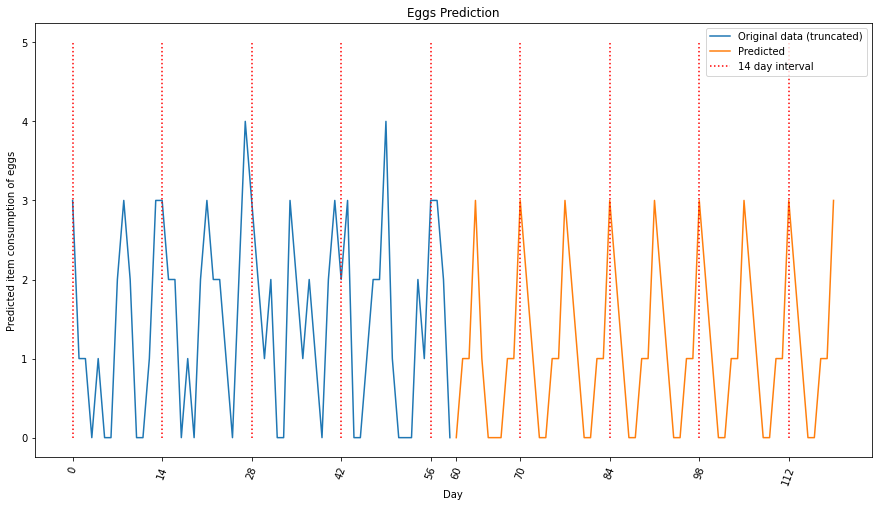

In [23]:
_,x,y = GEN_DATA(120, 3.5, testing=True)
num_predict = 60

# 60 points of training data, 60 for testing
# make a prediction of len 60 into the future

y_train, y_test = y[:len(y) - num_predict], y[len(y) - num_predict:]
x_train, x_test = x[:len(x) - num_predict], x[len(x) - num_predict:]
yhat = SARIMA_PREDICT(y_train, [[1, 0, 0], [1, 1, 1, 7]], num_predict)

DISPLAY_DATA(x_train, y_train, x_test, yhat, 'eggs')

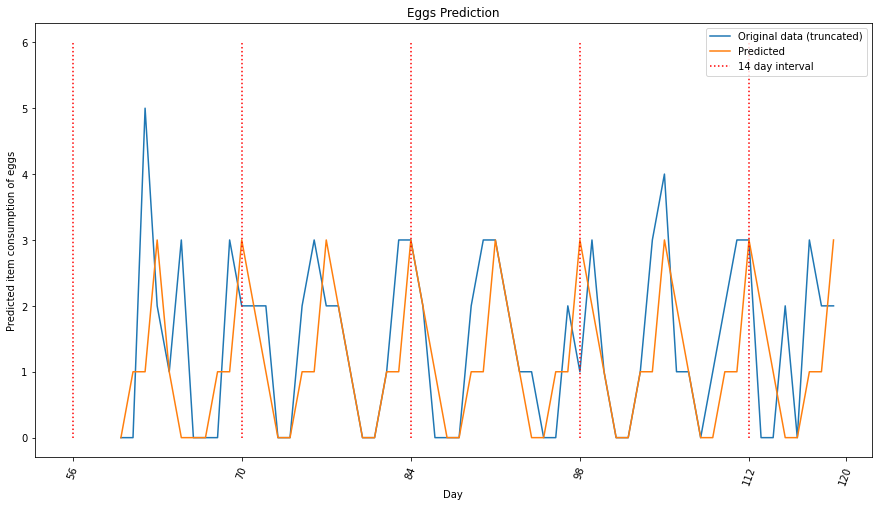

In [24]:
# show overlapping predictions on our test set
DISPLAY_DATA(x_test, y_test, x_test, yhat, 'eggs')

In [5]:
'''
Testing accuracy by running 500 iterations of newly generated data on the model.
We found that params [1,0,0], [1,1,1,7] worked the best for our test data.
'''

def run_once(order_params, seasonal_order_params):
    _,x,y = GEN_DATA(120, 3.5, testing=True)
    num_predict = 60

    # split so last 60 points will be test

    y_train, y_test = y[:len(y) - num_predict], y[len(y) - num_predict:]
    x_train, x_test = x[:len(x) - num_predict], x[len(x) - num_predict:]
    yhat = SARIMA_PREDICT(y_train, [order_params, seasonal_order_params], num_predict)
    
    return np.mean(abs(y_test - yhat))

order_params, seasonal_order_params = [1,0,0], [1,1,1,7]

totalErr = 0     
num_iters = 500
for _ in range(num_iters):
    totalErr += run_once(order_params, seasonal_order_params)

avgErr = totalErr / num_iters

print(f"Average error over 500 iterations for this SARIMA configuration: {avgErr}")

Average error over 500 iterations for this SARIMA configuration: 0.830433333333334


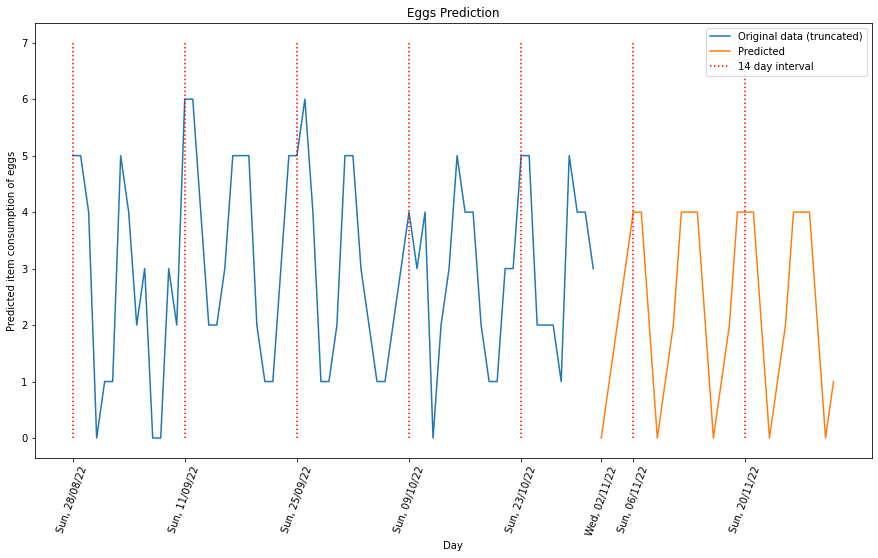

In [26]:
# this is actual use case

d,x,y = GEN_DATA(days_ago=60, noise_sd=1, peak_consume=5)

today = d+timedelta(days=len(x))

yhat = SARIMA_PREDICT(y, orders=[[1, 0, 0], [1, 1, 1, 7]], num_predict=30)
xhat = [x[-1] + i + 1 for i in range(len(yhat))]

item_name = 'eggs'

DISPLAY_DATA(x, y, xhat, yhat, item_name=item_name, date=d)